In [2]:
"""
COMPLETE OCR TESTING SYSTEM
Test CNN Model + Segmentation
"""

import os
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import defaultdict

# Check required files
print("="*70)
print("📂 CHECKING REQUIRED FILES")
print("="*70)

required_files = {
    'Model (best)': 'best_ocr_model.keras',
    'Model (final)': 'ocr_model.keras',
    'Class Mapping': 'class_mapping.json',
    'Metadata': 'model_metadata.json',
    'Test Image': 'test(3).jpeg'  # Ganti sesuai gambar kamu
}

all_ok = True
for name, file in required_files.items():
    if os.path.exists(file):
        size = os.path.getsize(file) / (1024*1024)  # MB
        print(f"✅ {name:<20}: {file} ({size:.1f} MB)")
    else:
        print(f"❌ {name:<20}: {file} - NOT FOUND!")
        all_ok = False

if all_ok:
    print("\n🎉 All files ready!")
else:
    print("\n⚠️  Some files missing!")

📂 CHECKING REQUIRED FILES
✅ Model (best)        : best_ocr_model.keras (4.9 MB)
✅ Model (final)       : ocr_model.keras (4.9 MB)
✅ Class Mapping       : class_mapping.json (0.0 MB)
✅ Metadata            : model_metadata.json (0.0 MB)
✅ Test Image          : test(3).jpeg (0.2 MB)

🎉 All files ready!


In [5]:
# ==================== HANDWRITING SEGMENTER ====================
import cv2
import numpy as np
from collections import defaultdict, Counter

class HandwritingSegmenter:
    def __init__(self, debug=False):
        self.debug = debug
        self.original_img = None
        self.processed_img = None
        self.mode = None
        self.characters = []
        self.char_info = []
        
    def detect_mode(self, gray):
        variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        mean_val = np.mean(gray)
        std_val = np.std(gray)
        
        if variance < 100 and mean_val > 200 and std_val < 50:
            return 'digital'
        else:
            return 'handwritten'
    
    def preprocess_handwritten(self, gray):
        denoised = cv2.bilateralFilter(gray, 9, 75, 75)
        thresh = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, blockSize=11, C=2)
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open)
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
        return closed
    
    def preprocess_digital(self, img):
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        kernel_dilate = np.ones((2, 2), np.uint8)
        dilated = cv2.dilate(cleaned, kernel_dilate, iterations=1)
        return dilated
    
    def remove_lines(self, thresh):
        img_h, img_w = thresh.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w/20), 1))
        horizontal_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h/20)))
        vertical_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
        lines = cv2.add(horizontal_lines, vertical_lines)
        cleaned = cv2.subtract(thresh, lines)
        return cleaned
    
    def group_into_lines(self, bboxes, y_tolerance=15):
        if not bboxes:
            return []
        sorted_boxes = sorted(bboxes, key=lambda b: b[1])
        lines = []
        current_line = [sorted_boxes[0]]
        current_y = sorted_boxes[0][1]
        
        for box in sorted_boxes[1:]:
            x, y, w, h = box
            if abs(y - current_y) <= y_tolerance:
                current_line.append(box)
            else:
                current_line.sort(key=lambda b: b[0])
                lines.append(current_line)
                current_line = [box]
                current_y = y
        
        if current_line:
            current_line.sort(key=lambda b: b[0])
            lines.append(current_line)
        return lines
    
    def is_valid_char(self, x, y, w, h, img_w, img_h, mode='handwritten'):
        if mode == 'digital':
            if w < 3 or h < 6 or w * h < 30:
                return False
            aspect = w / float(h)
            if aspect > 5 or aspect < 0.08 or w > img_w * 0.9 or h > img_h * 0.3:
                return False
        else:
            if w < 5 or h < 8 or w * h < 50:
                return False
            aspect = w / float(h)
            if aspect > 4 or aspect < 0.1 or w > img_w * 0.7 or h > img_h * 0.5:
                return False
        return True
    
    def split_connected_chars(self, roi, bbox, mode='handwritten'):
        x, y, w, h = bbox
        vertical_proj = np.sum(roi, axis=0)
        vertical_proj = vertical_proj / float(h) if h > 0 else vertical_proj
        threshold = np.mean(vertical_proj) * (0.2 if mode == 'digital' else 0.3)
        min_width = 20 if mode == 'digital' else 35
        
        valleys = []
        in_valley = False
        valley_start = 0
        
        for i, val in enumerate(vertical_proj):
            if val < threshold and not in_valley:
                in_valley = True
                valley_start = i
            elif val >= threshold and in_valley:
                valley_mid = (valley_start + i) // 2
                valleys.append(valley_mid)
                in_valley = False
        
        good_valleys = [v for v in valleys if 0.2*w < v < 0.8*w]
        
        if good_valleys and w > min_width:
            split_point = good_valleys[0]
            return [(roi[:, :split_point], (x, y, split_point, h)),
                    (roi[:, split_point:], (x+split_point, y, w-split_point, h))]
        return [(roi, bbox)]
    
    def extract_char(self, roi):
        h, w = roi.shape
        target_size = 28
        padding = 4
        max_dim = target_size - 2 * padding
        
        if w > h:
            scale = max_dim / float(w)
            new_w, new_h = max_dim, max(1, int(h * scale))
        else:
            scale = max_dim / float(h)
            new_w, new_h = max(1, int(w * scale)), max_dim
        
        try:
            resized = cv2.resize(roi, (new_w, new_h), interpolation=cv2.INTER_AREA)
        except:
            return None
        
        canvas = np.zeros((target_size, target_size), dtype=np.uint8)
        start_x, start_y = (target_size - new_w) // 2, (target_size - new_h) // 2
        canvas[start_y:start_y+new_h, start_x:start_x+new_w] = resized
        return canvas
    
    def detect_word_boundaries(self, line_boxes):
        if len(line_boxes) < 2:
            return []
        gaps = []
        for i in range(len(line_boxes) - 1):
            x1, y1, w1, h1 = line_boxes[i]
            x2, y2, w2, h2 = line_boxes[i + 1]
            gap = x2 - (x1 + w1)
            avg_width = (w1 + w2) / 2
            gaps.append((i, gap, avg_width))
        
        word_boundaries = []
        for i, gap, avg_width in gaps:
            if gap > avg_width * 1.5:
                word_boundaries.append(i + 1)
        return word_boundaries
    
    def process(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            print(f"❌ Error: Cannot read '{image_path}'")
            return None, [], []
        
        self.original_img = img.copy()
        img_h, img_w = img.shape[:2]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        self.mode = self.detect_mode(gray)
        
        if self.mode == 'digital':
            thresh = self.preprocess_digital(img)
        else:
            thresh = self.preprocess_handwritten(gray)
        
        cleaned = self.remove_lines(thresh)
        contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        all_bboxes = []
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if self.is_valid_char(x, y, w, h, img_w, img_h, self.mode):
                all_bboxes.append((x, y, w, h))
        
        y_tol = 10 if self.mode == 'digital' else 20
        lines = self.group_into_lines(all_bboxes, y_tolerance=y_tol)
        
        self.characters = []
        self.char_info = []
        visualization = self.original_img.copy()
        char_counter = 0
        
        for line_idx, line_boxes in enumerate(lines):
            word_boundaries = self.detect_word_boundaries(line_boxes)
            char_in_line = 0
            
            for bbox in line_boxes:
                x, y, w, h = bbox
                roi = cleaned[y:y+h, x:x+w]
                splits = self.split_connected_chars(roi, bbox, self.mode)
                
                for sub_roi, (sx, sy, sw, sh) in splits:
                    char_img = self.extract_char(sub_roi)
                    if char_img is not None:
                        is_word_start = char_in_line in word_boundaries
                        self.characters.append(char_img)
                        self.char_info.append({
                            'id': char_counter,
                            'line': line_idx,
                            'char_in_line': char_in_line,
                            'bbox': (sx, sy, sw, sh),
                            'is_word_start': is_word_start,
                            'split': len(splits) > 1
                        })
                        
                        color = (0, 255, 0) if len(splits) == 1 else (255, 165, 0)
                        cv2.rectangle(visualization, (sx, sy), (sx+sw, sy+sh), color, 1)
                        if is_word_start:
                            cv2.line(visualization, (sx-2, sy), (sx-2, sy+sh), (0, 0, 255), 2)
                        
                        char_counter += 1
                        char_in_line += 1
        
        self.processed_img = visualization
        return visualization, self.characters, self.char_info

print("✅ HandwritingSegmenter loaded!")

✅ HandwritingSegmenter loaded!


In [6]:
# ==================== OCR ENGINE ====================
class OCREngine:
    def __init__(self, model_path, mapping_path):
        print(f"🔧 Loading OCR Engine...")
        self.model = keras.models.load_model(model_path)
        print(f"   ✅ Model loaded: {model_path}")
        
        with open(mapping_path, 'r', encoding='utf-8') as f:
            mapping_data = json.load(f)
        self.class_mapping = {int(k): v for k, v in mapping_data.items()}
        print(f"   ✅ Loaded {len(self.class_mapping)} classes")
    
    def predict_batch(self, char_images):
        if not char_images:
            return []
        
        batch = []
        for img in char_images:
            if img.shape != (28, 28):
                img = cv2.resize(img, (28, 28))
            batch.append(img)
        
        batch = np.array(batch).reshape(-1, 28, 28, 1).astype('float32') / 255.0
        predictions = self.model.predict(batch, verbose=0)
        labels = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)
        
        results = []
        for label, conf in zip(labels, confidences):
            char = self.class_mapping.get(label, '?')
            results.append((char, conf, label))
        return results
    
    def reconstruct_text(self, predictions, char_info):
        lines = defaultdict(list)
        for (char, conf, label), info in zip(predictions, char_info):
            if info['is_word_start'] and lines[info['line']]:
                lines[info['line']].append(' ')
            lines[info['line']].append(char)
        
        return '\n'.join([''.join(lines[i]) for i in sorted(lines.keys())])
    
    def process_image(self, image_path, segmenter):
        print("\n" + "="*70)
        print("🔍 COMPLETE OCR PIPELINE")
        print("="*70)
        print(f"\nProcessing: {image_path}\n")
        
        # Step 1: Segment
        print("1️⃣  Segmenting...")
        result_img, characters, char_info = segmenter.process(image_path)
        
        if not characters:
            print("❌ No characters detected!")
            return None, None, None
        
        print(f"   ✅ Detected {len(characters)} characters")
        
        # Step 2: Recognize
        print("\n2️⃣  Recognizing...")
        results = self.predict_batch(characters)
        print(f"   ✅ Recognition complete")
        
        # Step 3: Reconstruct
        print("\n3️⃣  Reconstructing text...")
        text = self.reconstruct_text(results, char_info)
        
        # Statistics
        avg_conf = np.mean([conf for _, conf, _ in results])
        low_conf = sum([1 for _, conf, _ in results if conf < 0.7])
        
        print(f"\n📊 Statistics:")
        print(f"   • Total: {len(results)} characters")
        print(f"   • Avg confidence: {avg_conf:.2%}")
        print(f"   • Low confidence (<70%): {low_conf}")
        
        print(f"\n📝 Recognized Text:")
        print("="*70)
        print(text)
        print("="*70)
        
        # Visualize
        self.visualize(result_img, characters, results, char_info)
        
        return text, results, char_info
    
    def visualize(self, segmented_img, characters, results, char_info):
        # Segmentation result
        plt.figure(figsize=(16, 10))
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Segmentation: {len(characters)} characters', fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Character grid
        num_show = min(50, len(characters))
        fig, axes = plt.subplots(5, 10, figsize=(15, 8))
        axes = axes.flatten()
        
        for i in range(50):
            if i < num_show:
                char, conf, _ = results[i]
                color = 'green' if conf >= 0.9 else ('orange' if conf >= 0.7 else 'red')
                axes[i].imshow(characters[i], cmap='gray')
                axes[i].set_title(f'{char}\n{conf:.1%}', fontsize=9, color=color, fontweight='bold')
            axes[i].axis('off')
        
        plt.suptitle('Recognition Results (First 50)', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("✅ OCREngine class loaded!")

# ==================== INITIALIZE SYSTEM ====================
print("\n" + "="*70)
print("🚀 INITIALIZING OCR SYSTEM")
print("="*70)

# Load OCR Engine
ocr = OCREngine('best_ocr_model.keras', 'class_mapping.json')

# Load Segmenter
segmenter = HandwritingSegmenter()

print("\n✅ System ready!")
print("   Use: ocr.process_image('your_image.jpg', segmenter)")


✅ OCREngine class loaded!

🚀 INITIALIZING OCR SYSTEM
🔧 Loading OCR Engine...
   ✅ Model loaded: best_ocr_model.keras
   ✅ Loaded 129 classes

✅ System ready!
   Use: ocr.process_image('your_image.jpg', segmenter)



🔍 COMPLETE OCR PIPELINE

Processing: test(4).png

1️⃣  Segmenting...
   ✅ Detected 67 characters

2️⃣  Recognizing...
   ✅ Recognition complete

3️⃣  Reconstructing text...

📊 Statistics:
   • Total: 67 characters
   • Avg confidence: 49.69%
   • Low confidence (<70%): 49

📝 Recognized Text:
k
kT E h T ZM k j
h
W
HE Fj T k M k
8 j k j E E
T E
8 T E T
7 E T E E e
4 I X E j KE T T
B j X
B k X
8 4
j E
k k
T T J E j T Z
T


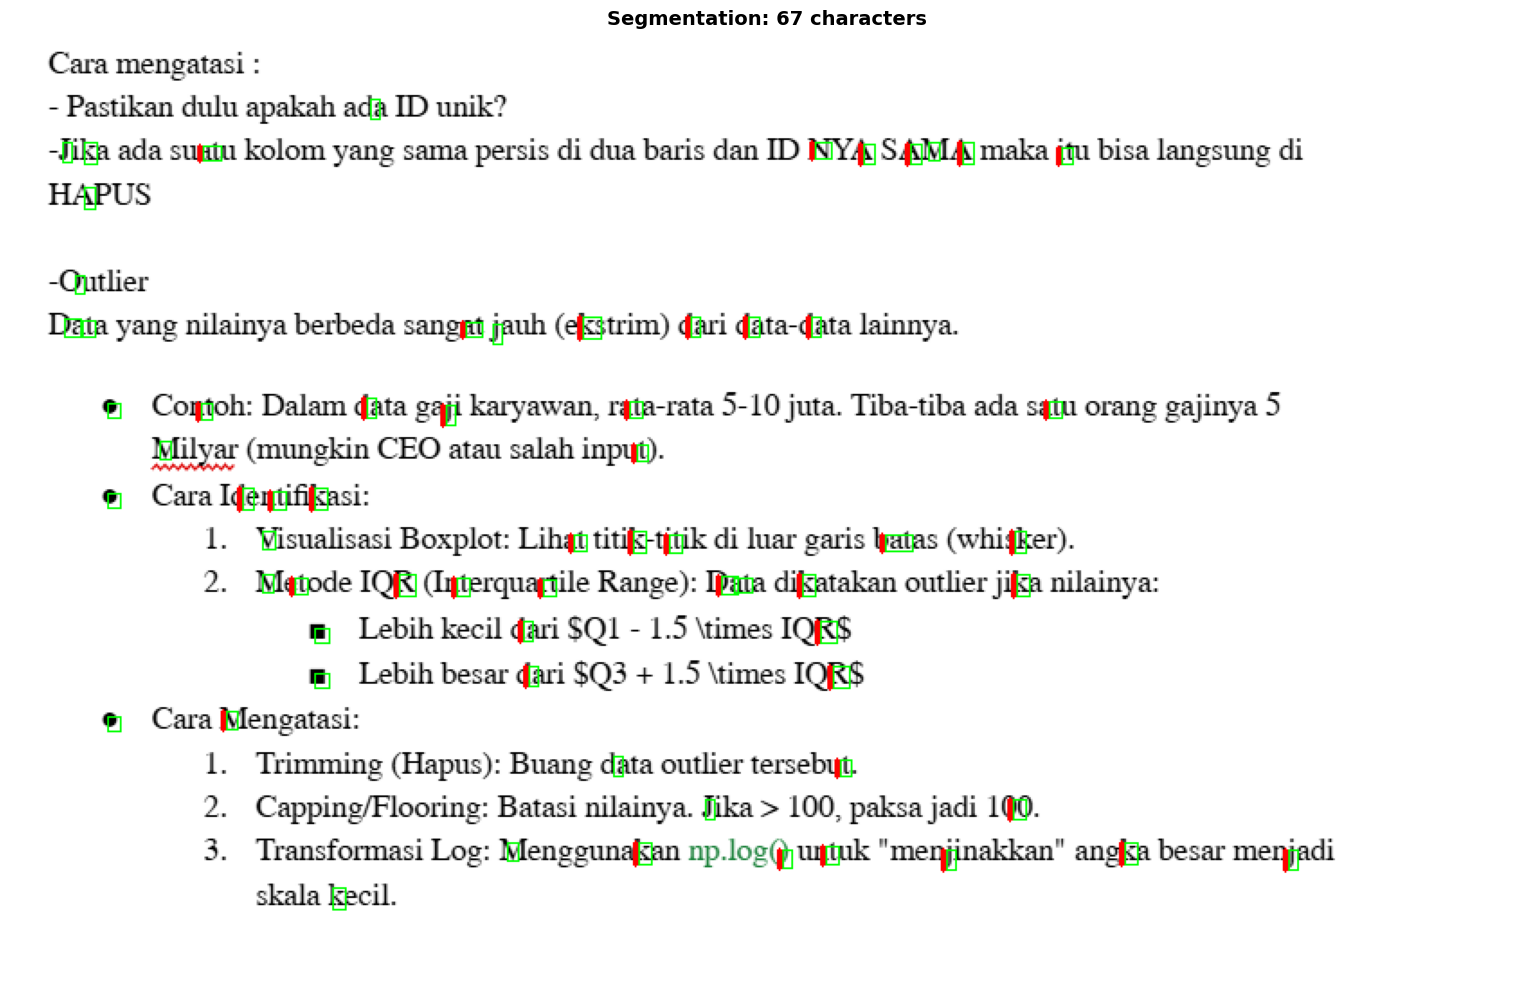

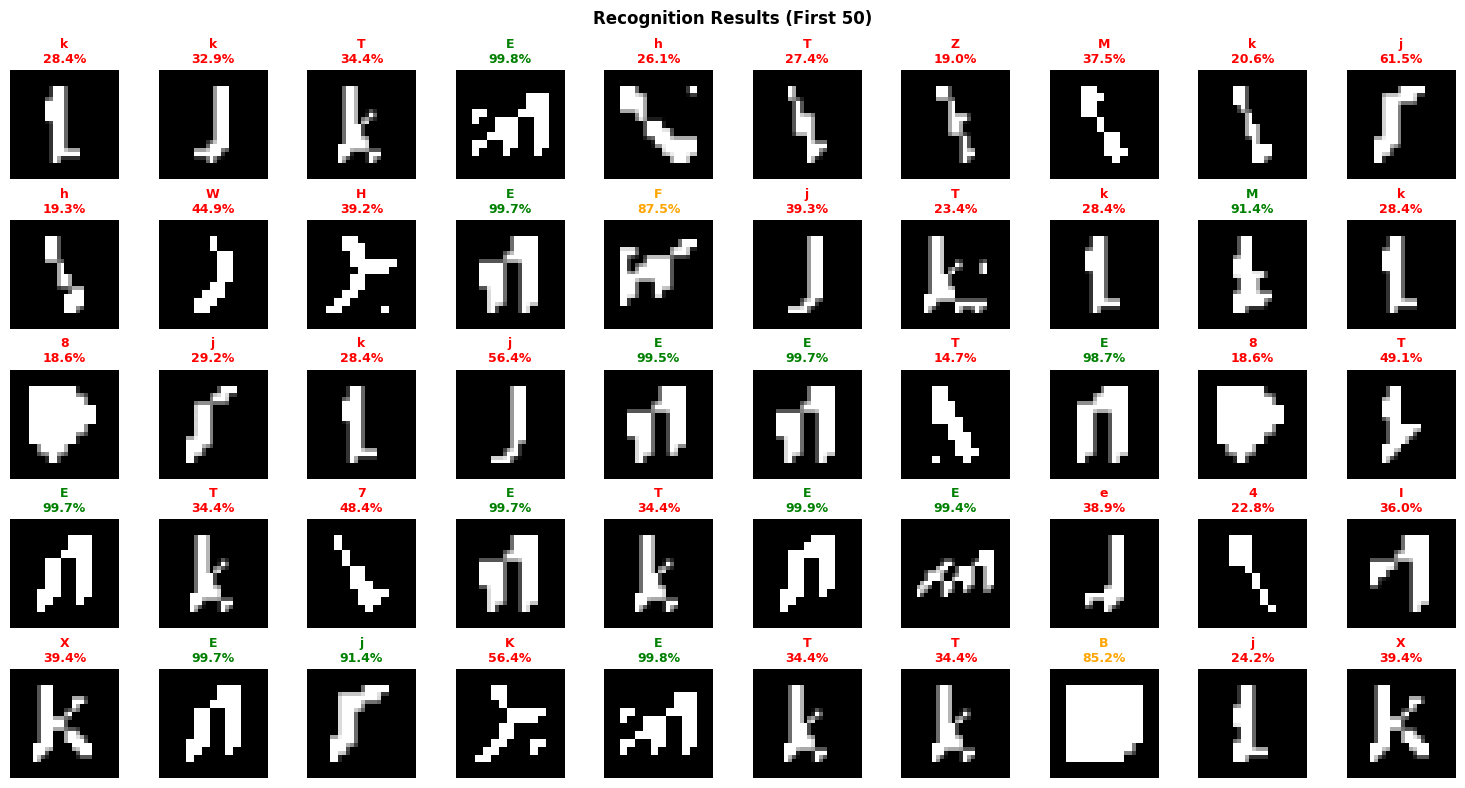

In [8]:
# ==================== TEST OCR ====================
test_image = 'test(4).png'  # GANTI dengan gambar kamu

text, results, info = ocr.process_image(test_image, segmenter)